In [ ]:
!pip install --user --upgrade pip
!pip install --user --upgrade tqdm
!pip install --user --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#!pip install "jax[cpu]===0.3.14" -f https://whls.blob.core.windows.net/unstable/index.html --use-deprecated legacy-resolver

In [1]:
# change directory to parent
import os
os.chdir('..')
print(os.getcwd())

/nfs/git/InteractiveInference/src/hello_world


In [2]:
%matplotlib inline

In [3]:
import importlib

import matplotlib.pyplot as plt
import numpy as np


from tqdm import tqdm

import jax
import jax.numpy as jnp

jax_key = jax.random.PRNGKey(42)
print(f"JAX devices: {jax.devices()}")
print(f"JAX device type: {jax.devices()[0].device_kind}")
#jax.default_device(jax.devices("gpu")[1])

import minimal_agent as ma_np
import minimal_agent_jax as ma_jax
import minimal_environment as me

JAX devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
JAX device type: NVIDIA RTX A6000


<module 'minimal_environment' from '/nfs/git/InteractiveInference/src/hello_world/minimal_environment.py'>

In [4]:
def jax_safelog(x):
  return jnp.log( jnp.maximum(x, 1e-16 ))

def jax_step_naive_fun(num_actions, o, q, πs, p_o, p_t, log_p_c):
    """ Deterministic policy selection with pragmatic value and state information gain."""
    # update belief from new observation
    joint = q * p_o[:,o]
    q = joint / joint.sum()
    # policy rollout: 
    step = lambda q, a: (q @ p_t[:,a,:], q @ p_t[:,a,:])
    qs_π = lambda q, π: jax.lax.scan(step, init=q, xs=π)[1]
    qs_πs = jax.vmap(qs_π, in_axes=(None, 0), out_axes=(0))
    q_ss = qs_πs(q, πs)
    # pragmatic value
    pragmatic = (q_ss @ log_p_c).sum(axis=1)
    # state info gain
    p_oo = q_ss @ p_o # prior
    joint = q_ss[...,None] * p_o
    q_oo = joint / joint.sum( axis=2, keepdims=True ) # conditional
    d_oo = (q_oo * (jax_safelog( q_oo ) - jax_safelog( q_ss )[...,None])).sum( axis=2 ) # KL
    info_gain = (d_oo * p_oo).sum(axis=(1, 2)) # sum over o and t
    # action selection
    π = πs[jnp.argmax(pragmatic + info_gain)]
    # propagate belief through time
    q = q @ p_t[:,π[0],:]
    return q, π

jit_step_naive_fun = jax.jit(jax_step_naive_fun, static_argnums=(0,))

def jax_step_batched_fun(num_actions, o, q, πs, p_o, p_t, log_p_c):
    """ Deterministic policy selection with pragmatic value and state information gain."""
    # update belief from new observation
    joint = q * p_o[:,o]
    q = joint / joint.sum()
    
    # policy rollout: 
    # coalesced access to transition dynamics speeds up vectorised rollouts across policies
    def step(q, a):
        # iterate over values of a
        def step_a(i, q):
            is_a = (a==i)
            # weighted average between q and q' with binary weight
            q = (1-is_a) * q + is_a * (q @ p_t[:,i,:]) # replace with q + is_a (q @ p_t[:,i,:] - q)
            return q
        
        q = jax.lax.fori_loop(0, num_actions, step_a, q)
        return q, q
    
    qs_π = lambda q, π: jax.lax.scan(step, init=q, xs=π)[1]
    qs_πs = jax.vmap(qs_π, in_axes=(None, 0), out_axes=(0)) # carry, output
    
    # batching policies helps avoid GPU out of memory errors
    def batch_nefe(q, πs):
        q_ss = qs_πs(q, πs)
        pragmatic = (q_ss @ log_p_c).sum(axis=1)
        # state info gain
        p_oo = q_ss @ p_o # prior
        joint = q_ss[...,None] * p_o
        q_oo = joint / joint.sum( axis=2, keepdims=True ) # conditional
        d_oo = (q_oo * (jax_safelog( q_oo ) - jax_safelog( q_ss )[...,None])).sum( axis=2 ) # KL
        info_gain = (d_oo * p_oo).sum(axis=(1, 2)) # sum over o and t
        nefe = pragmatic + info_gain
        return q, nefe
    
    nefe = jax.lax.scan(batch_nefe, init=q, xs=πs)[1] # scan over batches
    # action selection
    π = πs.reshape(-1, πs.shape[-1])[jnp.argmax(nefe)]
    # propagate belief through time
    q = q @ p_t[:,π[0],:]
    return q, π

jit_step_batched_fun = jax.jit(jax_step_batched_fun, static_argnums=(0,))

class MinimalAgentJax:
    """ Minimal agent performing exact inference in fully discrete POMDPs"""
    def __init__(self, 
                 env,
                 target_state, 
                 k=2, 
                 num_batches=1):
        self.env = env
        self.target_state = target_state
        self.k = k
        self.num_batches = num_batches
        
        self.p_t = jnp.asarray(env.p_s1_given_s_a)
        self.p_o = jnp.asarray(env.p_o_given_s)
        print(f'Enumerating {self.env.a_N**k:,} candidate policies of length {k}')
        self.πs = np.stack(np.meshgrid(*[np.arange(self.env.a_N) for _ in range(k)])).T.reshape(-1, k)
        self.πs = jax.device_put(self.πs)
        # slow naive implementation
        #self.πs = jnp.asarray([x for x in itertools.product( range(self.env.a_N), repeat=self.k )])
        
    def reset(self):
        # initialize state preference
        q_star = np.eye(self.env.s_N)[self.target_state] \
                 + 1/(self.env.s_N*5) * np.ones(self.env.s_N)
        self.q_star = q_star / q_star.sum()
        self.log_p_c = jnp.log( self.q_star )
        # initialize state prior as uniform
        self.q = jnp.asarray(np.ones(self.env.s_N) / self.env.s_N )
    
    def step(self, o, use_jit=True):
        params = {
            'num_actions': self.env.a_N,
            'o': o,
            'q': self.q,
            'p_o': self.p_o,
            'p_t': self.p_t,
            'log_p_c': self.log_p_c,
            'πs': self.πs.reshape(self.num_batches, -1, self.k),
        }
        self.q, π = jit_step_batched_fun(**params) if use_jit else jax_step_batched_fun(**params)
        return π[0]

In [6]:
importlib.reload(me)
importlib.reload(ma_np)
importlib.reload(ma_jax)

# numpy: 5 seconds per iteration with 32 states and 16 step time horizon
# jax: 3 iterations per second -> 15x faster
s_food = 0
s_0 = 5
target_state = 28
N = 32 # number states
k = 10 # planning horizon; run time increases exponentially with planning horizon
T = 128 # number of simulation steps

env = me.MinimalEnv(N=N, # number of states
                    s_food=s_food, # location of the food source
                    s_0=s_0, 
                    o_decay=0.15) # starting location 

agent_np = ma_np.MinimalAgent(env=env, target_state=target_state, k=k, use_info_gain=True, use_pragmatic_value=True, select_max_π=True)

agent_jax = ma_jax.MinimalAgentJax(env=env, 
                            target_state=target_state, 
                            k=k)

o = env.reset() # set state to starting state
agent_np.reset() # initialize belief state and target state distribution
agent_jax.reset() # initialize belief state and target state distribution

o = int(0)
agent_jax.step(o=o)

%timeit agent_np.step(int(o))
%timeit agent_jax.step(o=1)

JAX devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
JAX device type: NVIDIA RTX A6000
Thu Mar 30 12:52:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:21:00.0 Off |                  Off |
| 30%   33C    P2    22W / 300W |  48278MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

In [7]:
importlib.reload(ma_jax)
s_food = 0
s_0 = 6
target_state = 26
N = 32 # number states
k = 14 # planning horizon; run time increases exponentially with planning horizon
T = 128 # number of simulation steps

env = me.MinimalEnv(N=N, # number of states
                    s_food=s_food, # location of the food source
                    s_0=s_0, 
                    o_decay=0.1) # starting location 

agent_jax = ma_jax.MinimalAgentJax(env=env, target_state=target_state, k=k, num_batches=2**2)

o = env.reset() # set state to starting state
#agent_np.reset() # initialize belief state and target state distribution
agent_jax.reset() # initialize belief state and target state distribution

ss = [env.s_t]
qq = [agent_jax.q]
aa = []
    
for i in tqdm( range(T) ):
    π = agent_jax.step(int(o))
    a =  np.copy(π)
    o = env.step(a)
    ss.append(env.s_t)
    qq.append(jnp.copy(agent_jax.q))
    aa.append(a)

JAX devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
JAX device type: NVIDIA RTX A6000
Thu Mar 30 12:53:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:21:00.0 Off |                  Off |
| 30%   35C    P2    21W / 300W |  48278MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

100%|██████████| 128/128 [00:01<00:00, 124.59it/s]


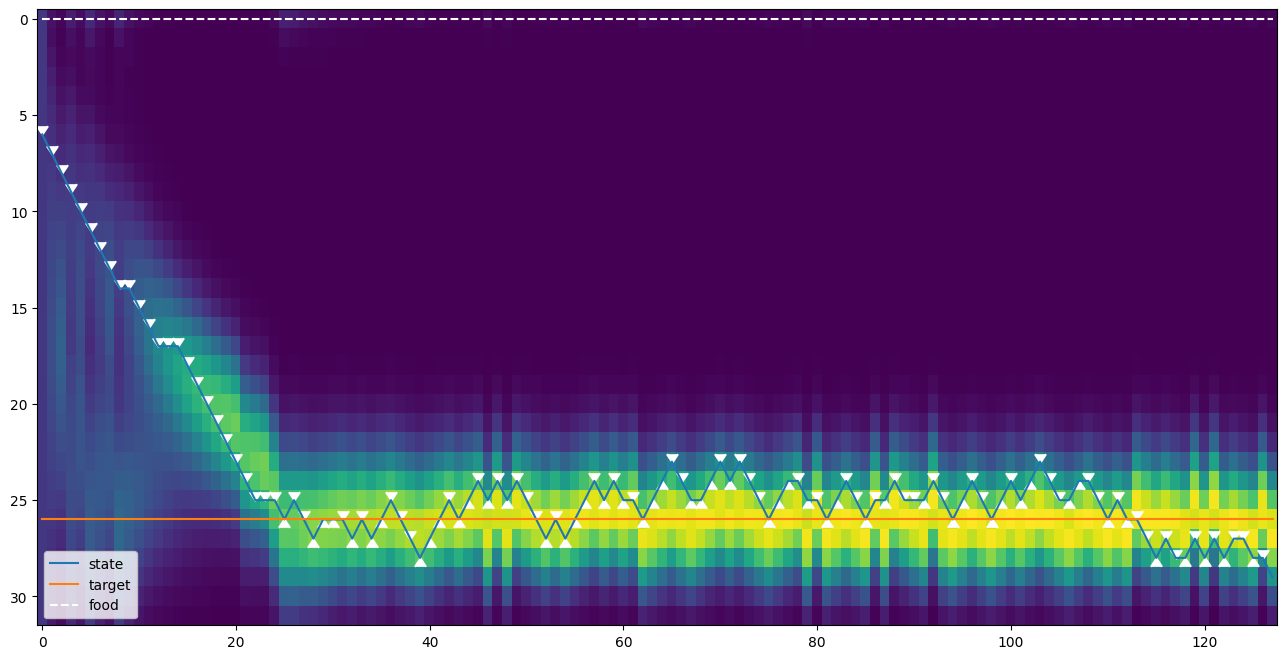

In [13]:
from matplotlib.markers import CARETUP, CARETDOWN
plot_steps = 128
aa = np.array(aa)[:plot_steps-1]
ss = np.array(ss)[:plot_steps]

fig, ax = plt.subplots(figsize=(16, 8))
plt.imshow(jnp.array(qq)[:plot_steps].T, label='belief', aspect='auto')
t = np.arange(len(aa))
i_left = t[aa==0]
i_right = t[aa==1]
plt.scatter(i_left, ss[:-1][i_left], s=8**2, c='white', marker=CARETUP)
plt.scatter(i_right, ss[:-1][i_right], s=8**2, c='white', marker=CARETDOWN)
plt.plot(ss, label='state')
plt.plot([0, len(ss)-1], [target_state]*2, label='target')
plt.plot([0, len(ss)-1], [env.s_food]*2, 'w--', label='food')
plt.legend()
plt.show()

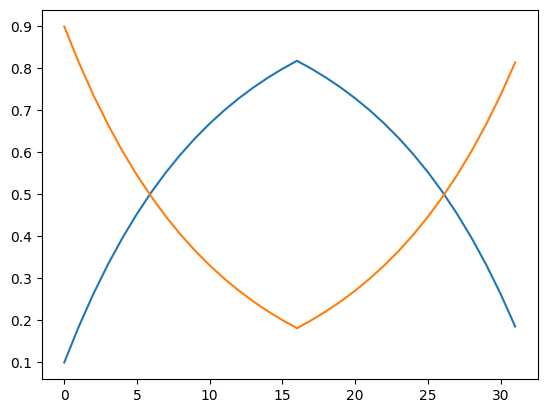

In [12]:
plt.plot(env.p_o_given_s)